This script interpriate the correlation between the chamber/ambient measured O3 (or O3 sensitivity) with PMF-solved factors

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.cm as cm
import plotly.express as px
import math
import os, importlib, sys

sys.path.append('../../code/src')
#importlib.reload(sys.modules['pmf_result'])
from pmf_result import pmf_output_to_df, plot_pmf_profile, plot_factor_time_series, reorder_factor, plot_CPF

# Input data

In [2]:
# extract PMF output
profile_conc, profile_perc_spec, profile_perc_factor, contribution = \
    pmf_output_to_df(43,9,'../../data/intermediate/PMF_output/Factor9')
new_order = ['Factor 7','Factor 1','Factor 4','Factor 9','Factor 6','Factor 5','Factor 2',
             'Factor 8','Factor 3']
#new_order = ['Factor 1','Factor 5','Factor 2','Factor 8','Factor 4','Factor 3','Factor 7',
#             'Factor 6','Factor 9']
profile_perc_spec = reorder_factor(profile_perc_spec, new_order)
profile_conc = reorder_factor(profile_conc, new_order)
contribution = reorder_factor(contribution, new_order)

# rename factor name in column
factor_name = ['Plant decomposition', 'Biogenic', 'Summer blend gasoline',
               'Winter blend gasoline', 'institutional refrigerator, air conditioning, cooking', 'Education institution', 'Commercial and industrial solvents', 
               'VCP(siloxane)', 'VCP(EtOH)']
profile_conc.columns = ['Parameter'] + factor_name
contribution.columns = ['Date'] + factor_name

In [12]:
# t test for weekday and weekend
contribution.loc[contribution['Date'].dt.weekday < 5, 'Weekday'] = 'Weekday'
contribution.loc[contribution['Date'].dt.weekday >= 5, 'Weekday'] = 'Weekend'

t_test = pd.DataFrame()
for factor in factor_name:
    df = contribution[[factor, 'Weekday']].dropna()
    t_test.loc['t value', factor], t_test.loc['p value', factor] = \
        st.ttest_ind(df[df['Weekday'] == 'Weekday'][factor], 
                     df[df['Weekday'] == 'Weekend'][factor])
t_test

,Plant decomposition,Biogenic,Summer blend gasoline,Winter blend gasoline,"institutional refrigerator, air conditioning, cooking",Education institution,Commercial and industrial solvents,VCP(siloxane),VCP(EtOH)
t value,1.184766,-0.828078,2.581810,1.570265,1.028724,-0.109765,0.965493,0.846219,0.249808
p value,0.238759,0.409487,0.011194,0.119334,0.305951,0.912803,0.336496,0.399337,0.803220


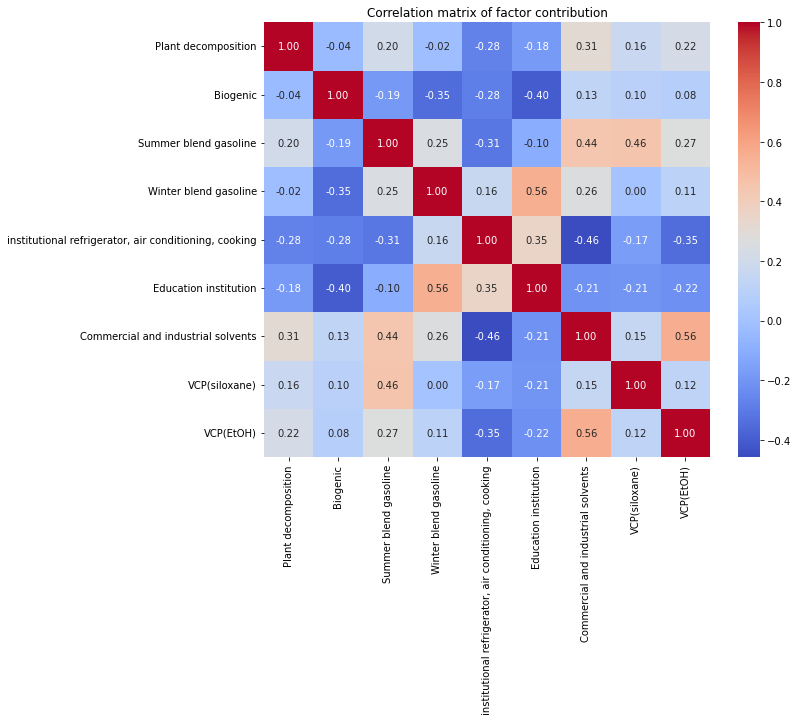

In [17]:
# correlation matrix of factor contribution
correlation = contribution[factor_name].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix of factor contribution')
plt.show()

In [3]:
# Temperature data (max)
df = pd.read_csv('../../data/raw/TEMP_PICKDATA_2021-12-31_RL.csv')
df = df[df['start_hour'].notna()]
df = df[['date','start_hour','value']]
df['value'] = (df['value']-32)*5/9
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].isin(contribution['Date'])]
df_temp_max = df.groupby('date').max().reset_index()[['date','value']]
df_temp_max.columns = ['Date','Temp_max']

# Temperature data (initial)
df = pd.read_csv('../../data/final/temp_morning_daily_avg_redlands.csv')
df['Date'] = pd.to_datetime(df['Date']) 
df = df[df['Date'].isin(contribution['Date'])]
df = df[['Date','Value']]
df_temp_init = df
df_temp_init.columns = ['Date','Temp_init']

In [4]:
# O3 data (MDA8 O3)
df_O3_MDA8 = pd.read_csv('../../data/final/MDA8_O3_redlands.csv')
df_O3_MDA8['Date'] = pd.to_datetime(df_O3_MDA8['Date'])

# O3 data (chamber O3)
df_O3_chamber = pd.read_csv('../../data/final/O3_sensitivity_redlands.csv')
df_O3_chamber['Date'] = pd.to_datetime(df_O3_chamber['Date'])

In [5]:
# merge data

df_pmf_O3 = contribution.merge(df_O3_MDA8[['Date','MDA8']], on='Date', how='left')
df_pmf_O3 = df_pmf_O3.merge(df_O3_chamber[['Date','b1_b2_3hr','bag2_3hr']], 
                            on='Date', how='left')
df_pmf_O3_temp = df_pmf_O3.merge(df_temp_init, on='Date', how='left')
df_pmf_O3_temp = df_pmf_O3_temp.merge(df_temp_max, on='Date', how='left')

## factor contribution vs. MDA8 O3

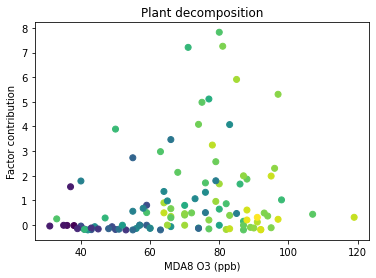

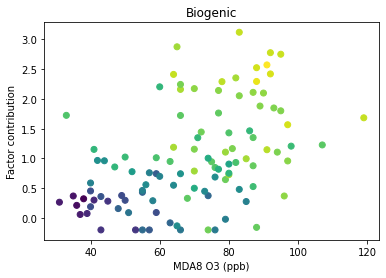

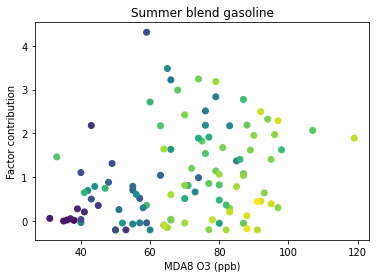

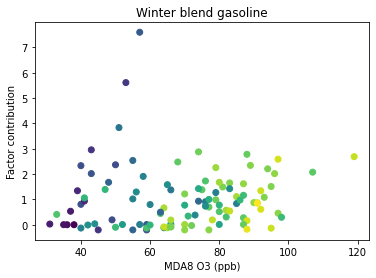

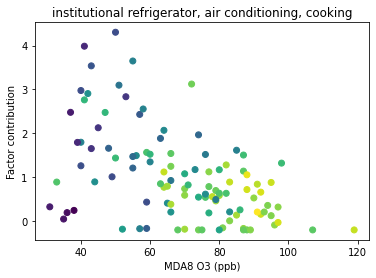

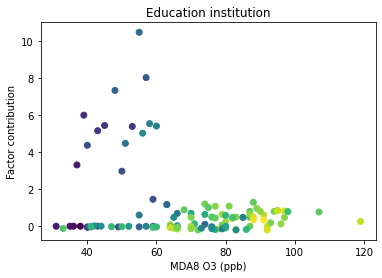

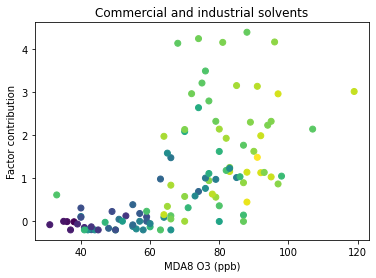

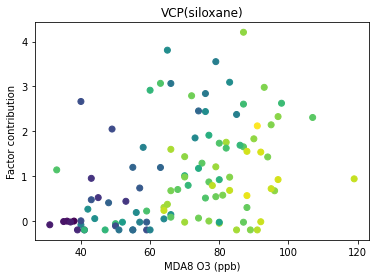

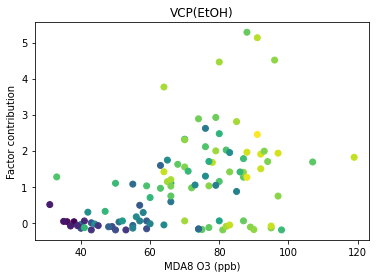

In [40]:
for i in np.arange(1,10,1):
    x = df_pmf_O3_temp['MDA8']
    y = df_pmf_O3_temp.iloc[:,i]
    title = df_pmf_O3_temp.columns[i]
    plt.scatter(x,y, c=df_pmf_O3_temp['Temp_init'], cmap='viridis')
    plt.xlabel('MDA8 O3 (ppb)')
    plt.ylabel('Factor contribution')
    plt.title(title)
    plt.show()


## factor contribution vs. temp

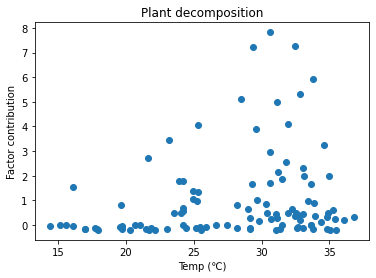

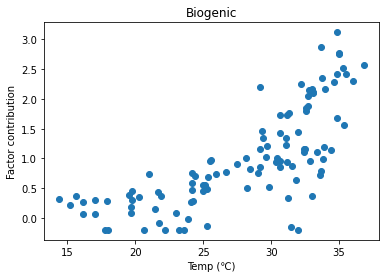

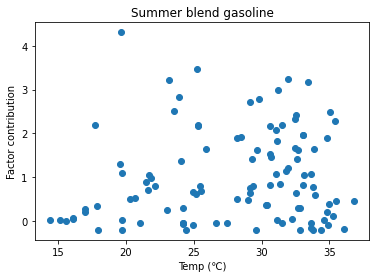

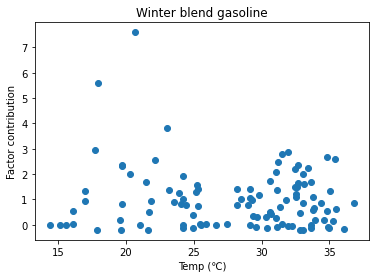

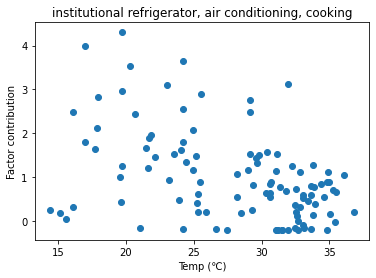

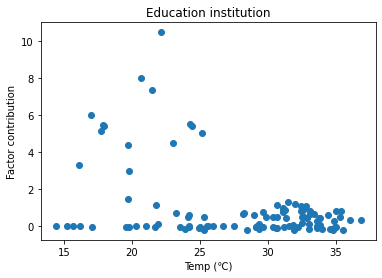

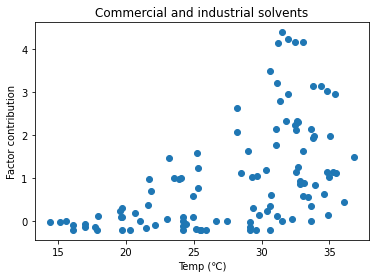

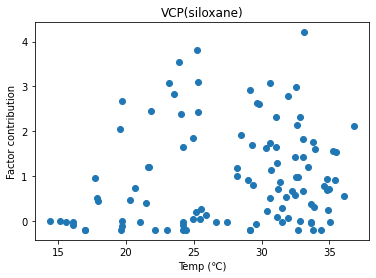

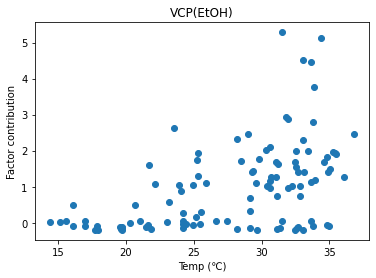

In [41]:
for i in np.arange(1,10,1):
    x = df_pmf_O3_temp['Temp_init']
    y = df_pmf_O3_temp.iloc[:,i]
    title = df_pmf_O3_temp.columns[i]
    plt.scatter(x,y)
    plt.xlabel('Temp (℃)')
    plt.ylabel('Factor contribution')
    plt.title(title)
    plt.show()

# factor contribution vs. O3 sensitivity

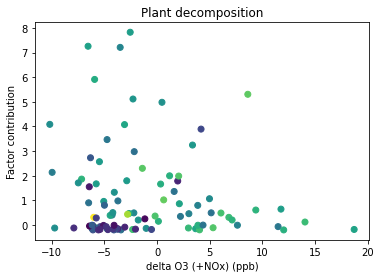

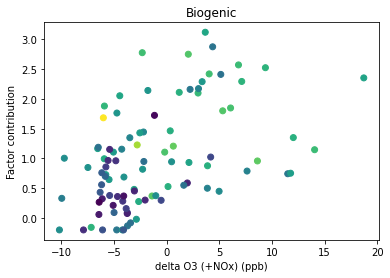

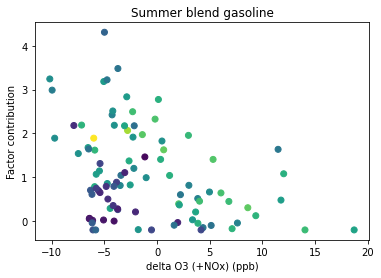

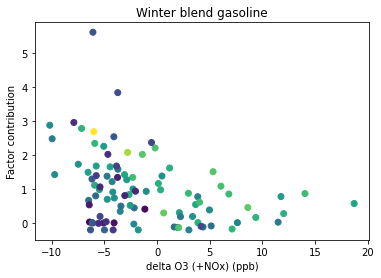

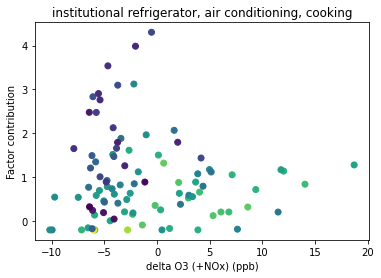

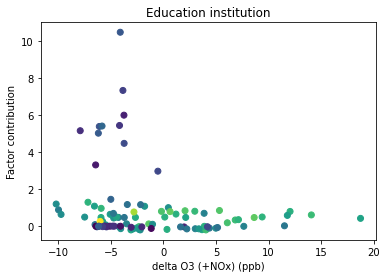

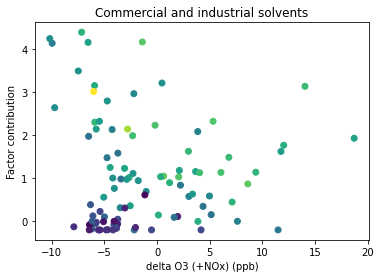

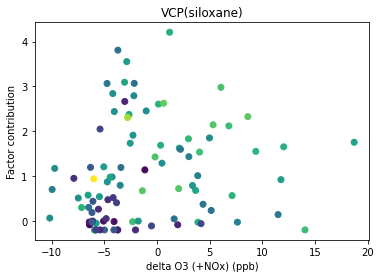

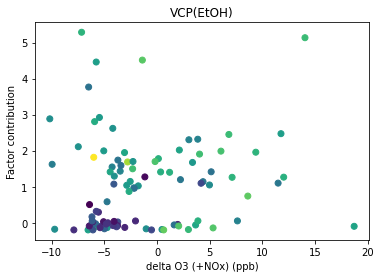

In [42]:
for i in np.arange(1,10,1):
    x = df_pmf_O3_temp['b1_b2_3hr']
    y = df_pmf_O3_temp.iloc[:,i]
    title = df_pmf_O3_temp.columns[i]
    plt.scatter(x,y, c=df_pmf_O3_temp['MDA8'], cmap='viridis')
    plt.xlabel('delta O3 (+NOx) (ppb)')
    plt.ylabel('Factor contribution')
    plt.title(title)
    plt.show()